In [1]:
import numpy as np
  
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, multiply, Lambda, add, Activation, Dropout
from keras.layers import concatenate
from keras.optimizers import *
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.preprocessing import image

import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix 
from sklearn.model_selection import KFold

import os
from os import listdir

import natsort # it may need to be installed by 'pip install natsort'

from google.colab.patches import cv2_imshow

import cv2
import datetime
now = datetime.datetime.now

# **Load the images**

In [2]:
#Regions of Interest in images
path_sals = "/content/Data/saliency/"

#Images
path_imgs = "/content/Data/images/"

#Ground Truth
path_masks = "/content/Data/masks/"

imagesList = listdir(path_sals)

In [3]:
imglist = natsort.natsorted(imagesList)

In [4]:
img_row = 256
img_col = 256
img_chnl = 1
btch_num = 4
epoch_num = 200 
input_size = (img_row, img_col, img_chnl)
num_imgs = len(imglist)
print("Number of images:", num_imgs)

Number of images: 163


In [5]:
def load_img(dir_path, imgs_list, imgs_array):
  for i in range(num_imgs):
    #Loading image in Python Image Library format
    tmp_img = image.load_img(path=os.path.join(dir_path, imgs_list[i]), target_size = input_size)
    #Converting image to numpy array format
    img = image.img_to_array(tmp_img)
    imgs_array[i] = img[:,:,0]/255.0
  imgs_array = np.expand_dims(imgs_array, axis=3)#expanding the dimensions to consider each value as one dimension
  return imgs_array


In [6]:
# Initialize the arrays
imgs = np.zeros((num_imgs, img_row, img_col))
masks = np.zeros_like(imgs)
sals = np.zeros_like(imgs)

imgs = load_img(path_imgs, imglist, imgs)
masks = load_img(path_masks, imglist, masks)
sals = load_img(path_sals, imglist, sals)

print("Images", imgs.shape)
print("Masks", masks.shape)
print("Sals", sals.shape)

Images (163, 256, 256, 1)
Masks (163, 256, 256, 1)
Sals (163, 256, 256, 1)


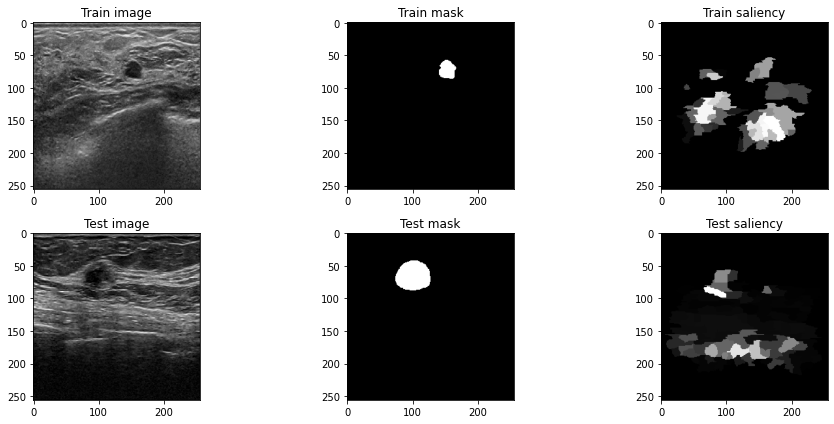

In [7]:
# Plot the first and last images
plt.figure(figsize = (14,6))
plt.subplot(231)
plt.imshow(np.squeeze(imgs[0]), cmap = "gray")
plt.title('Train image')
plt.subplot(232)
plt.imshow(np.squeeze(masks[0]), cmap = "gray")
plt.title('Train mask')
plt.subplot(233)
plt.imshow(np.squeeze(sals[0]), cmap = "gray")
plt.title('Train saliency')
plt.subplot(234)
plt.imshow(np.squeeze(imgs[-1]), cmap = "gray")
plt.title('Test image')
plt.subplot(235)
plt.imshow(np.squeeze(masks[-1]), cmap = "gray")
plt.title('Test mask')
plt.subplot(236)
plt.imshow(np.squeeze(sals[-1]), cmap = "gray")
plt.title('Test saliency')
plt.tight_layout()
plt.show()

# **Performance Metrics**

**Dice Score Coefficient and Dice loss**

In [8]:
def dsc(y_true, y_pred):
    smooth = 1.
    # masks
    y_true_fm = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_fm * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_fm) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dsc(y_true, y_pred)
    return loss

**Dice score, Jaccard Index(IOU), Recall, Sensitivity**

In [9]:
def auc(y_true, y_pred):
    y_pred_positives = np.round(np.clip(y_pred, 0, 1))
    y_pred_negatives = 1 - y_pred_positives
    y_positives = np.round(np.clip(y_true, 0, 1)) # ground truth
    y_negatives = 1 - y_positives
    true_positive = np.sum(y_positives * y_pred_positives)
    true_negative = np.sum(y_negatives * y_pred_negatives)
    false_positive = np.sum(y_negatives * y_pred_positives)
    false_negative = np.sum(y_positives * y_pred_negatives)
    recall = (true_positive + K.epsilon()) / (true_positive + false_negative + K.epsilon()) 
    #tnr = (tn + K.epsilon()) / (tn + fp + K.epsilon())
    prec = (true_positive + K.epsilon()) / (true_positive + false_positive + K.epsilon()) 
    iou = (true_positive + K.epsilon()) / (true_positive + false_negative + false_positive + K.epsilon()) #intersection over union
    dsc = (2*true_positive + K.epsilon()) / (2*true_positive + false_negative + false_positive + K.epsilon()) #dice score
    return [dsc, iou, recall, prec]

# **Network**

In [10]:
def Network(input_layer, start_neurons):
    input = Input(shape=input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)

    conv4 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)

    # Middle
    convm = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(convm)
    
    deconv4 = Conv2DTranspose(start_neurons * 2, (2, 2), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(start_neurons * 2, (2, 2), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 1, (2, 2), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (2, 2), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)

    model = Model(inputs = input, outputs = output_layer)
    
    return model

#output_layer = Network(input_size, 32)

# **Training and Cross Validation**

Run # 1
Training time: 0:02:11.639186
Testing time: 0:00:00.323078
------------------------------
USING THRESHOLD 0.5

 DSC 		0.729 
 IOU 		0.627 
 Recall 	0.693 
 Precision	0.882


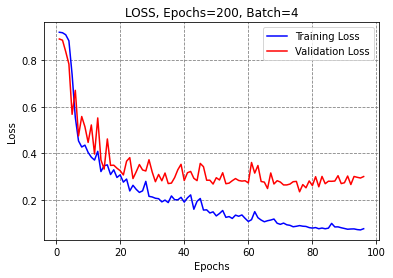

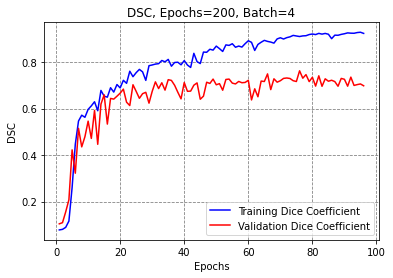

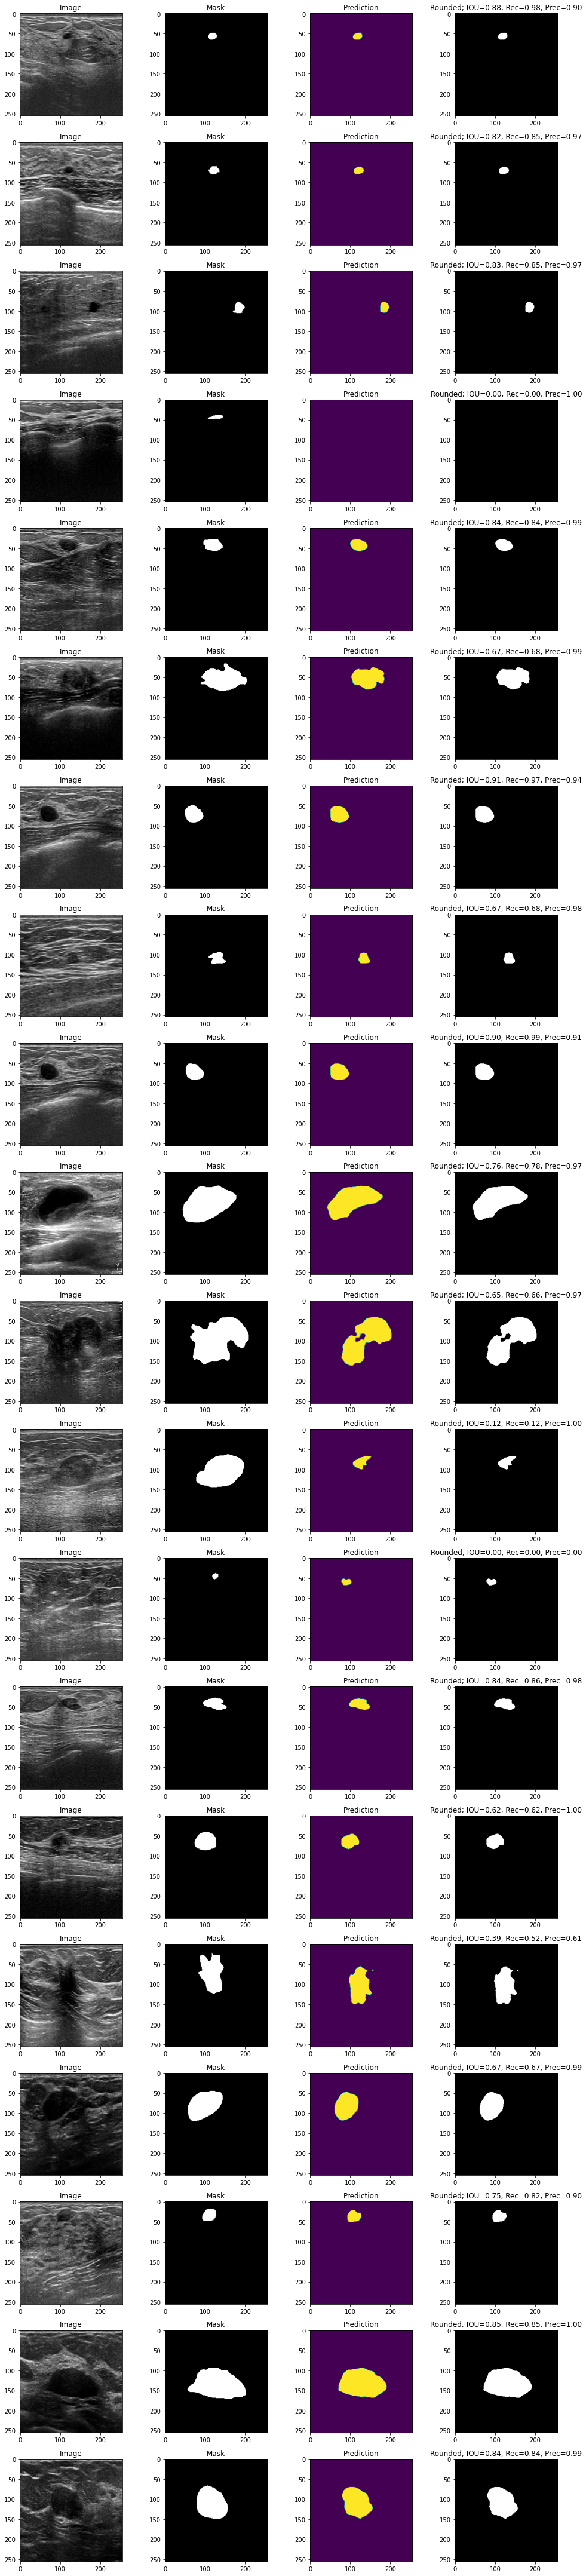

Global Accuracy: 0.9783407071741616

Area under the ROC curve: 0.9500460771877838
Run # 2
Training time: 0:02:07.390085
Testing time: 0:00:00.333186
------------------------------
USING THRESHOLD 0.5

 DSC 		0.651 
 IOU 		0.547 
 Recall 	0.661 
 Precision	0.801


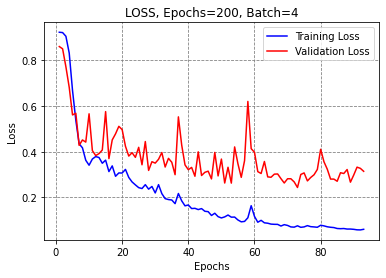

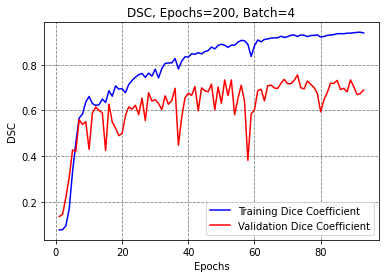

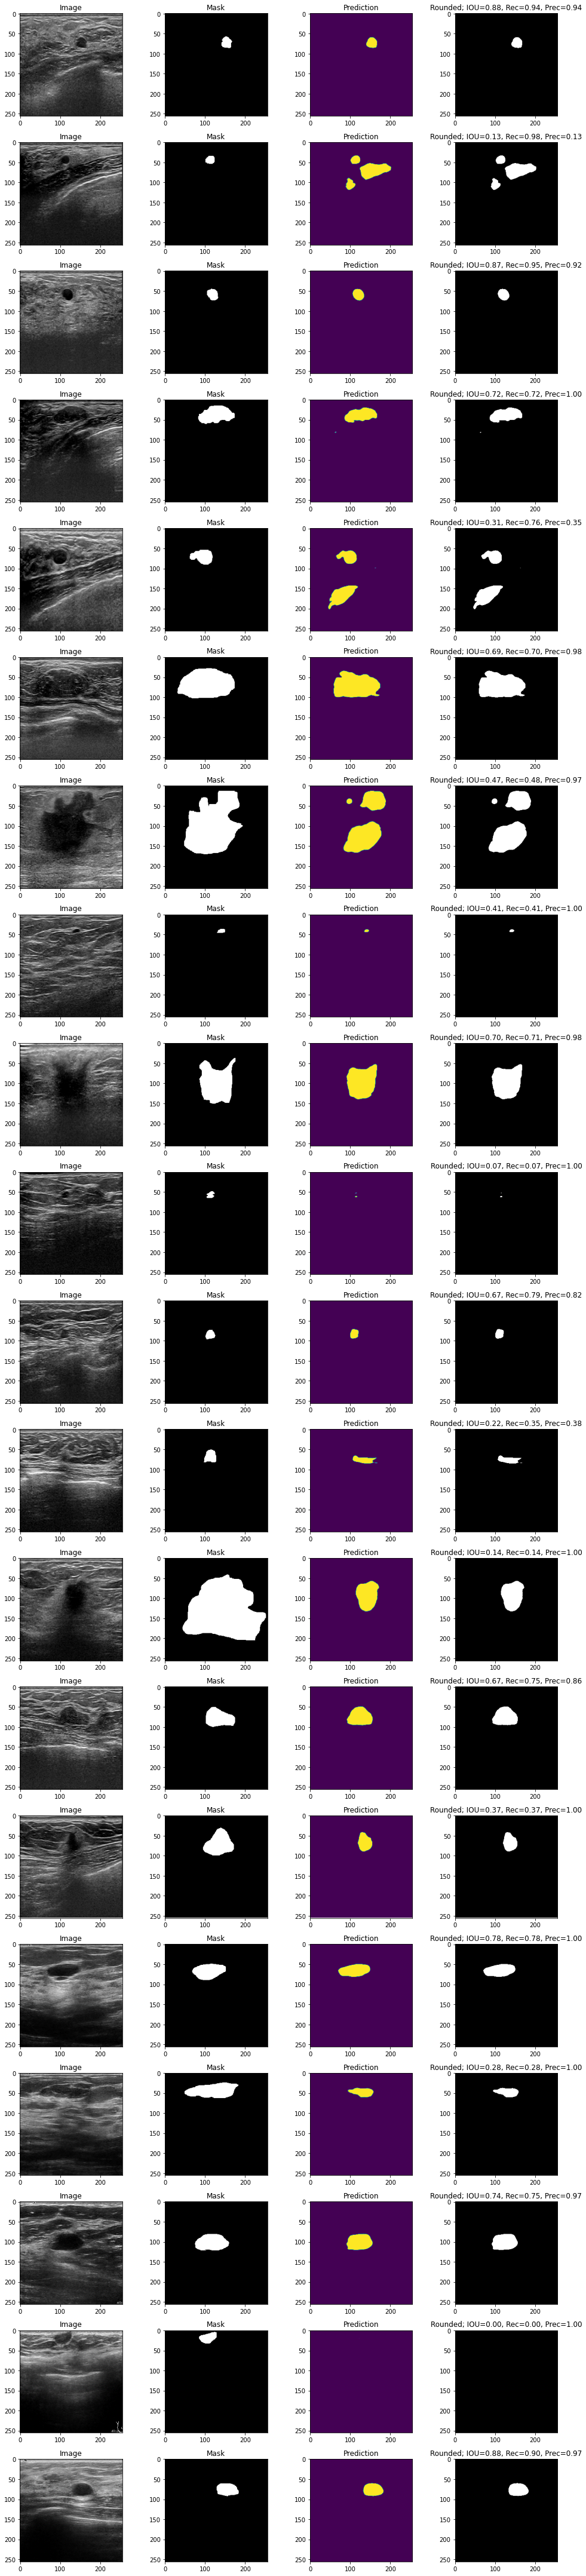

Global Accuracy: 0.9725784673923399

Area under the ROC curve: 0.8994112441758413
Run # 3
Training time: 0:02:23.181480
Testing time: 0:00:00.335501
------------------------------
USING THRESHOLD 0.5

 DSC 		0.635 
 IOU 		0.539 
 Recall 	0.604 
 Precision	0.833


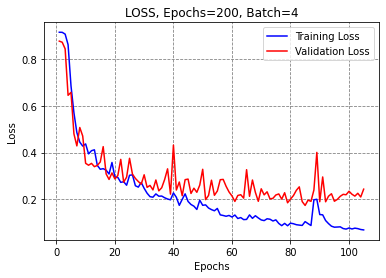

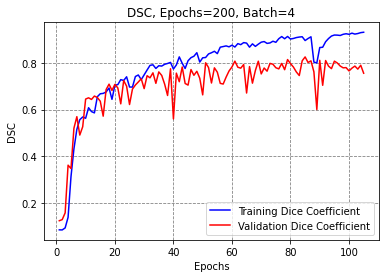

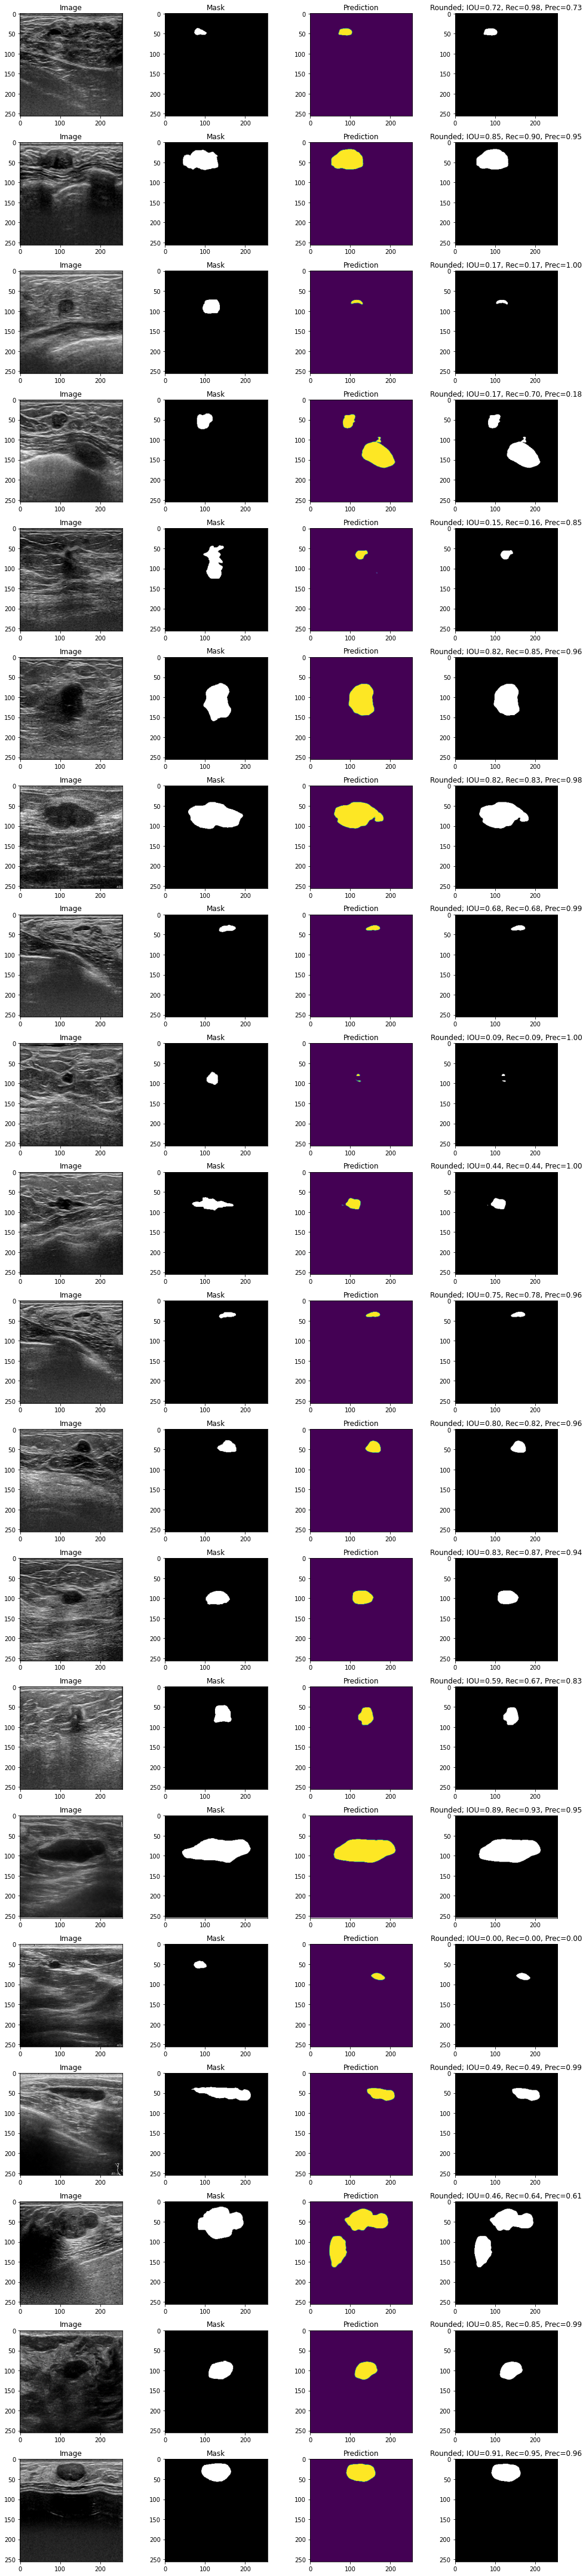

Global Accuracy: 0.9796749208031631

Area under the ROC curve: 0.9120242408861527
Run # 4
Training time: 0:03:32.905110
Testing time: 0:00:00.313761
------------------------------
USING THRESHOLD 0.5

 DSC 		0.733 
 IOU 		0.649 
 Recall 	0.744 
 Precision	0.860


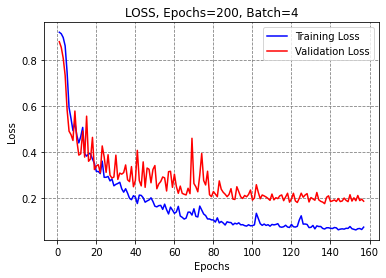

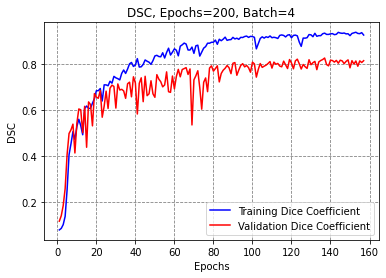

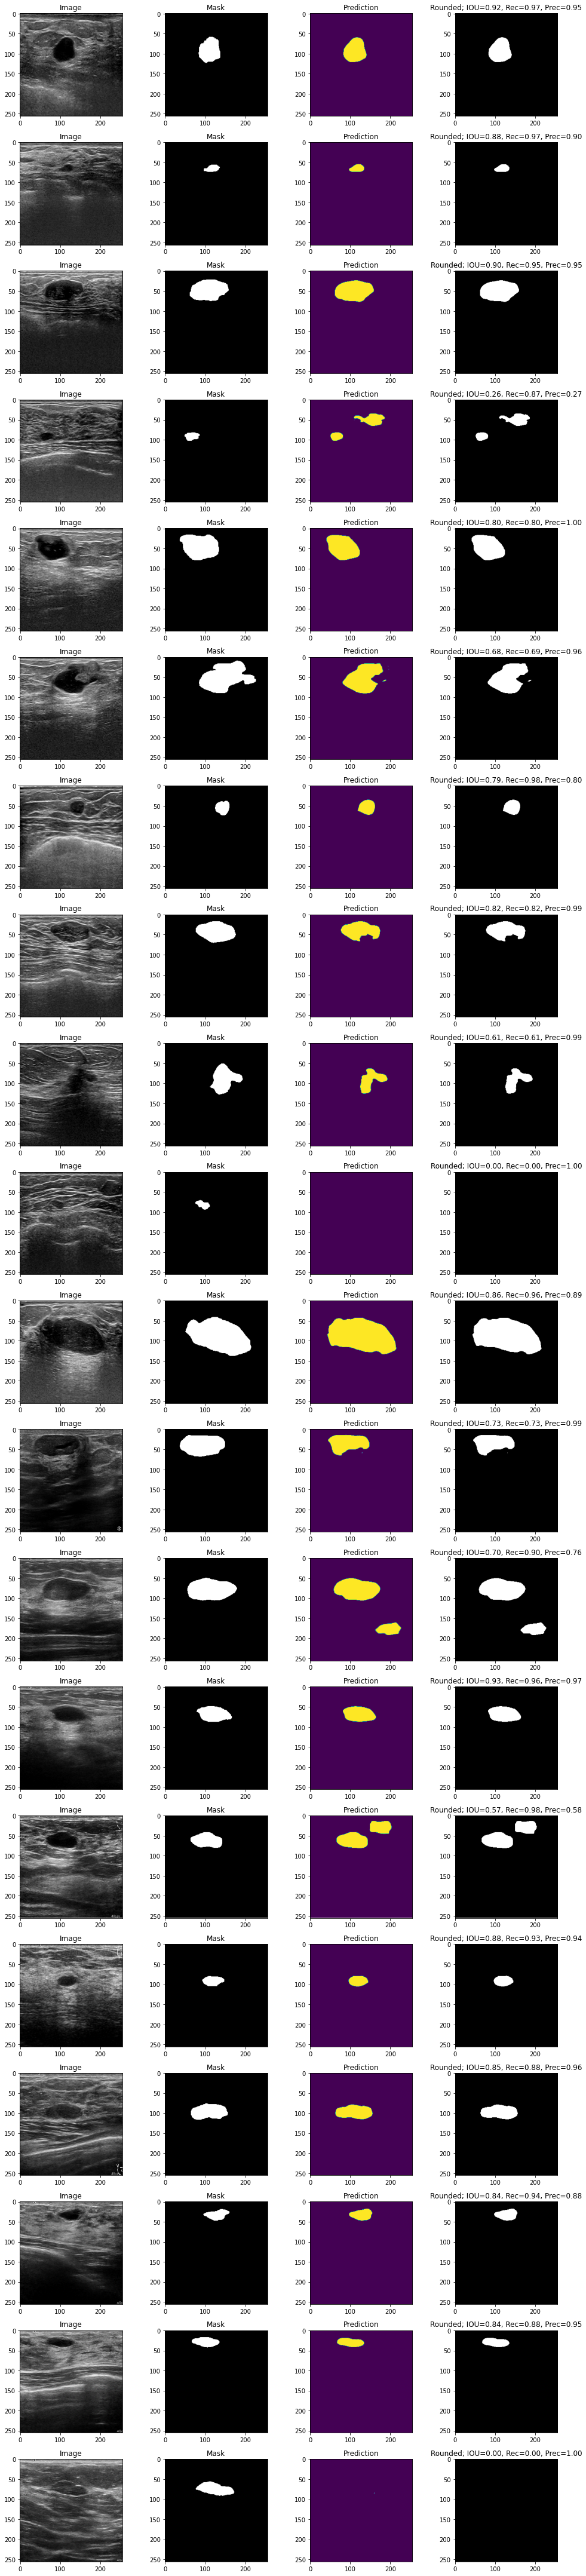

Global Accuracy: 0.9824047088623047

Area under the ROC curve: 0.9350981476689453


In [15]:
# Evaluate the models using using k-fold cross-validation
n_folds = 4

epoch_nos = np.zeros(n_folds,)
dice_score_nos = np.zeros(n_folds,)
iou_nos = np.zeros_like(dice_score_nos)
recall_nos = np.zeros_like(dice_score_nos)
precision_nos = np.zeros_like(dice_score_nos)
global_acc_nos = np.zeros_like(dice_score_nos)
auc_roc_nos = np.zeros_like(dice_score_nos)

# Prepare cross-validation
kfold = KFold(n_folds, shuffle=True, random_state=1)

run = 0;
# enumerate splits
for train, test in kfold.split(imgs):
    
    # Display the run number
    print('Run #', run+1)
    
    # Define the model
    model = Network(input_size, 32)
    
    # Split into train and test sets
    imgs_train, masks_train, imgs_test, masks_test = imgs[train], masks[train], imgs[test], masks[test]

    # Compile and fit the  model
    model.compile(optimizer = Adam(lr = 0.0001), loss = dice_loss, metrics = [dsc])

    t = now()
    callbacks = [EarlyStopping(monitor='val_loss', patience = 20)]
    history = model.fit(imgs_train, masks_train, validation_split=0.15, batch_size=btch_num, 
                        epochs=epoch_num, verbose=0, callbacks=callbacks)
    
    print('Training time: %s' % (now() - t))
    
    # PLot the loss and accuracy
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['dsc'] 
    val_acc = history.history['val_dsc']

    epochsn = np.arange(1, len(train_loss)+1,1)
    plt.plot(epochsn,train_loss, 'b', label='Training Loss')
    plt.plot(epochsn,val_loss, 'r', label='Validation Loss')
    plt.grid(color='gray', linestyle='--')
    plt.legend()
    plt.title('LOSS, Epochs={}, Batch={}'.format(epoch_num, btch_num))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.figure()
    plt.plot(epochsn, acc, 'b', label='Training Dice Coefficient')
    plt.plot(epochsn, val_acc, 'r', label='Validation Dice Coefficient')
    plt.grid(color='gray', linestyle='--')
    plt.legend()            
    plt.title('DSC, Epochs={}, Batch={}'.format(epoch_num, btch_num))
    plt.xlabel('Epochs')
    plt.ylabel('DSC')
    
    # Make predictions
    t = now()
    preds = model.predict(imgs_test)
    print('Testing time: %s' % (now() - t))
    
    # Evaluate model
    num_test = len(test)
    # Calculate performance metrics
    dsc_sc = np.zeros((num_test,1))
    iou_sc = np.zeros_like(dsc_sc)
    rec_sc = np.zeros_like(dsc_sc)
    tn_sc = np.zeros_like(dsc_sc)
    prec_sc = np.zeros_like(dsc_sc)
    thresh = 0.5
    for i in range(num_test):
        dsc_sc[i], iou_sc[i], rec_sc[i], prec_sc[i] = auc(masks_test[i], preds[i] >thresh)
    print('-'*30)
    print('USING THRESHOLD', thresh)
    print('\n DSC \t\t{0:^.3f} \n IOU \t\t{1:^.3f} \n Recall \t{2:^.3f} \n Precision\t{3:^.3f}'.format(
            np.sum(dsc_sc)/num_test,  
            np.sum(iou_sc)/num_test,  
            np.sum(rec_sc)/num_test,
            np.sum(prec_sc)/num_test ))
    
    # Plot the predicted masks
    num_disp = 20
    j=1
    plt.figure(figsize = (14,num_disp*3))
    for i in range(num_disp):
        plt.subplot(num_disp,4,j)
        plt.imshow(np.squeeze(imgs_test[i]), cmap='gray')
        plt.title('Image')
        j +=1
        plt.subplot(num_disp,4,j)
        plt.imshow(np.squeeze(masks_test[i]),cmap='gray')
        plt.title('Mask')
        j +=1
        plt.subplot(num_disp,4,j)
        plt.imshow(np.squeeze(preds[i]))
        plt.title('Prediction')
        j +=1
        plt.subplot(num_disp,4,j)
        plt.imshow(np.squeeze(np.round(preds[i])), cmap='gray')
        plt.title('Rounded; IOU=%0.2f, Rec=%0.2f, Prec=%0.2f' %(iou_sc[i], rec_sc[i], prec_sc[i]))
        j +=1
    plt.tight_layout()
    plt.show()    
    
    # Confusion matrix
    confusion = confusion_matrix( masks_test.ravel(),preds.ravel()>thresh)
    accuracy = 0
    if float(np.sum(confusion))!=0:
        accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
    print("Global Accuracy: " +str(accuracy))
    
    # Area under the ROC curve
    AUC_ROC = roc_auc_score(preds.ravel()>thresh, masks_test.ravel())
    print("\nArea under the ROC curve: " +str(AUC_ROC))
    
    # Save outputs 
    epoch_nos[run] = epochsn[-1]
    dice_score_nos[run] = np.sum(dsc_sc)/num_test
    iou_nos[run] = np.sum(iou_sc)/num_test
    recall_nos[run] = np.sum(rec_sc)/num_test
    precision_nos[run] = np.sum(prec_sc)/num_test
    global_acc_nos[run] = accuracy
    auc_roc_nos[run] = AUC_ROC
    run +=1

In [16]:
# Display the scores in a table
import pandas
from pandas import DataFrame
df = DataFrame({'Epochs Number': epoch_nos, 'Dice Score': dice_score_nos, 'IOU Score': iou_nos, 'Recall (Sensitivity)': recall_nos, 'Precision': precision_nos, 'Global Accuracy': global_acc_nos, 'AUC-ROC': auc_roc_nos})
df

Epochs Number  Dice Score  IOU Score  ...  Precision  Global Accuracy   AUC-ROC
0           96.0    0.729092   0.626796  ...   0.882495         0.978341  0.950046
1           93.0    0.650859   0.546851  ...   0.801498         0.972578  0.899411
2          105.0    0.635265   0.538692  ...   0.833061         0.979675  0.912024
3          157.0    0.733348   0.649297  ...   0.860472         0.982405  0.935098

[4 rows x 7 columns]

In [17]:
# Calculate mean values of the scores
epoch_nos_mean = np.mean(epoch_nos)
dice_score_nos_mean = np.mean(dice_score_nos)
iou_mean = np.mean(iou_nos)
recall_mean = np.mean(recall_nos)
precision_mean = np.mean(precision_nos)
global_acc_mean = np.mean(global_acc_nos)
auc_roc_mean = np.mean(auc_roc_nos)

# Mean values of the scores
df2 = DataFrame({'Epochs Number Mean': epoch_nos_mean, 'Dice Score Mean': dice_score_nos_mean, 'IOU Score Mean': iou_mean, 'Recall (Sensitivity) Mean': recall_mean, 'Precision Mean': precision_mean, 'Global Accuracy Mean': global_acc_mean, 'AUC-ROC Mean': auc_roc_mean},index=[5])
df2

Epochs Number Mean  Dice Score Mean  ...  Global Accuracy Mean  AUC-ROC Mean
5              112.75         0.687141  ...               0.97825      0.924145

[1 rows x 7 columns]

In [14]:
# Calculate standard deviations of the scores
dice_std = np.std(dice_score_nos)
iou_std = np.std(iou_nos)
rec_std = np.std(recall_nos)
prec_std = np.std(precision_nos)
globacc_std = np.std(global_acc_nos)
auc_roc_std = np.std(auc_roc_nos)

# Standard deviations of the scores
df3 = DataFrame({'Dice Score STD': dice_std, 'IOU Score STD': iou_std, 'Recall (Sensitivity) STD': rec_std, 'Precision STD': prec_std, 'Global Accuracy STD': globacc_std, 'AUC-ROC STD': auc_roc_std}, index=[5])
df3

Dice Score STD  IOU Score STD  ...  Global Accuracy STD  AUC-ROC STD
5        0.067833       0.068244  ...             0.005468     0.033216

[1 rows x 6 columns]